In [87]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tabpfn import TabPFNClassifier
import matplotlib.pyplot as plt
from scipy.stats import randint
import pandas as pd

df = pd.read_csv("../titanic/Titanic-Dataset.csv")

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [89]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [90]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [91]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df['HasCabin'] = df['Cabin'].notna().astype(int)
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
df['Sex'] = df['Sex'].map({'male' : 0, 'female' : 1})

df['Embarked'] = df['Embarked'].fillna('Missing')
df['EmbarkedCat'] = pd.factorize(df['Embarked'])[0]

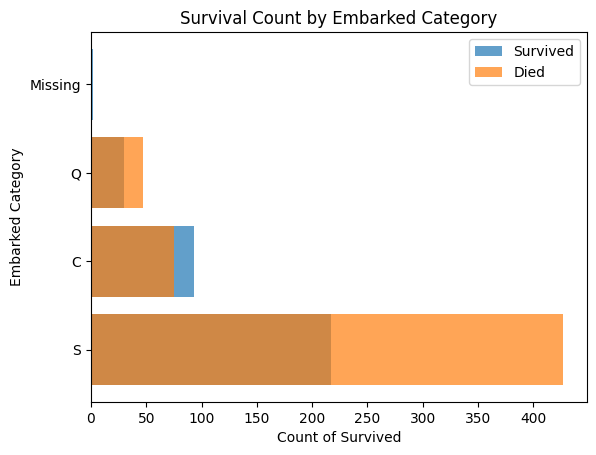

In [92]:
labels = pd.factorize(df['Embarked'])[1] 
location_lived = df[df['Survived'] == 1].groupby('EmbarkedCat').size()
location_death = df[df['Survived'] == 0].groupby('EmbarkedCat').size()

plt.figure()
plt.barh(location_lived.index, location_lived.values, label="Survived", alpha=0.7)
plt.barh(location_death.index, location_death.values, label="Died", alpha=0.7)
plt.yticks(location_lived.index, labels)
plt.xlabel('Count of Survived')
plt.ylabel('Embarked Category')
plt.title('Survival Count by Embarked Category')
plt.legend()
plt.show()

In [93]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
HasCabin         0
FamilySize       0
IsAlone          0
EmbarkedCat      0
dtype: int64

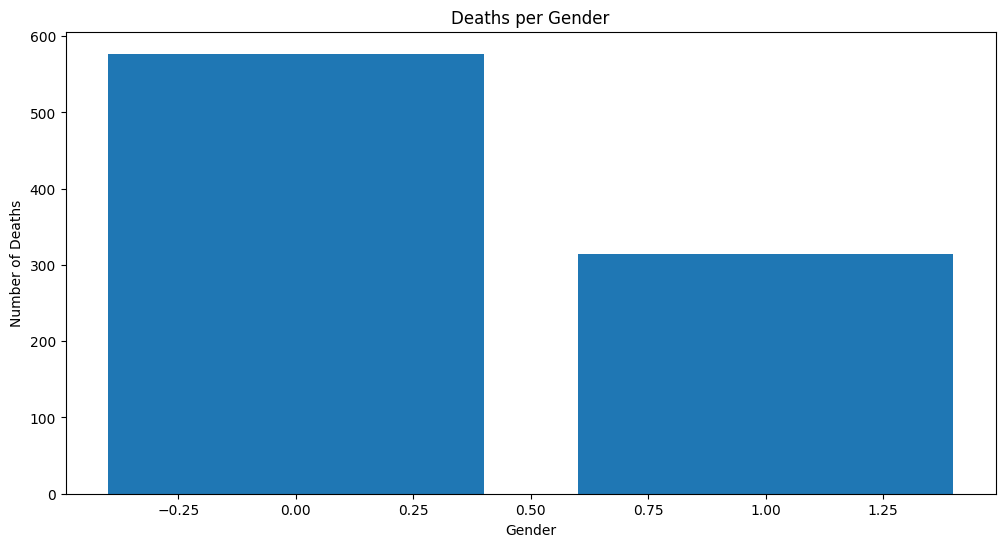

In [94]:
age_gender = df[['Survived', 'Sex']].groupby('Sex').count()

plt.figure(figsize=(12, 6))
plt.bar(age_gender.index, age_gender['Survived'])
plt.title('Deaths per Gender')
plt.ylabel('Number of Deaths')
plt.xlabel('Gender')
plt.show()



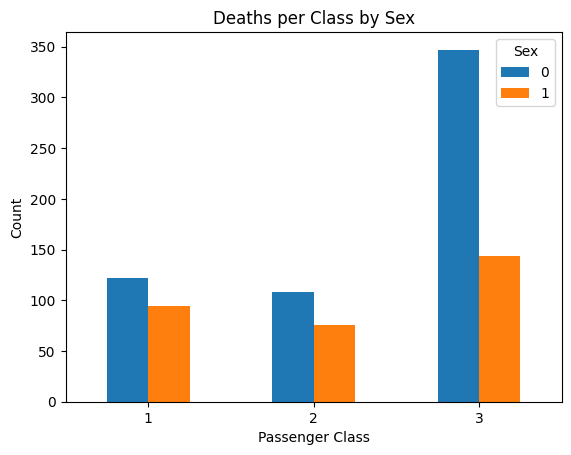

In [95]:
deaths_per_class = df[['Survived', 'Sex', 'Pclass']].groupby(['Pclass', 'Sex']).size().unstack(fill_value=0)
#plt.figure()
#plt.bar(deaths_per_class.index, deaths_per_class['Survived'])
#plt.show()
deaths_per_class.plot(kind='bar')
plt.title('Deaths per Class by Sex')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Sex')
plt.show()

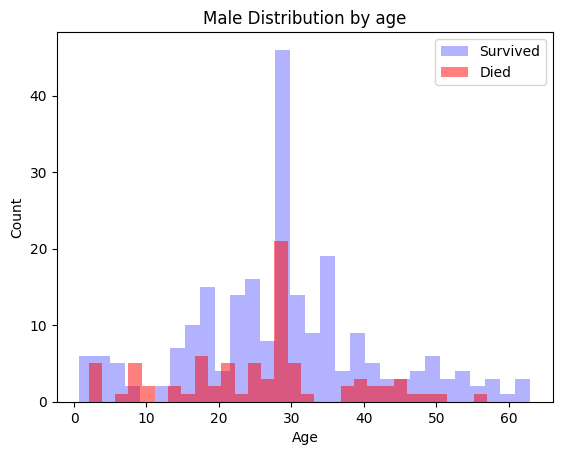

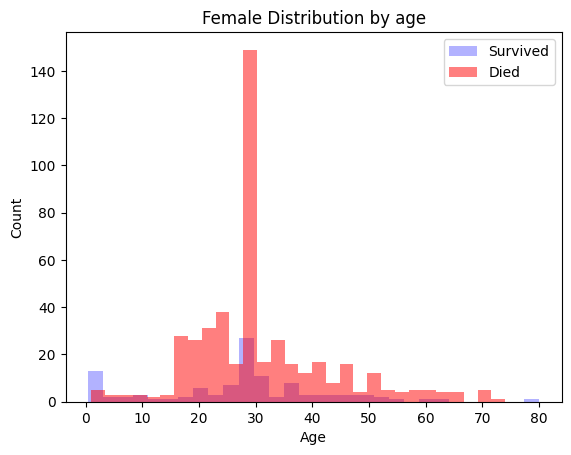

In [96]:
male = df[df['Sex'] == 1]
female = df[df['Sex'] == 0]

plt.figure()
plt.hist(male[male["Survived"] == 1]["Age"], bins=30, alpha=0.3, label="Survived", color='blue')
plt.hist(male[male["Survived"] == 0]["Age"], bins=30, alpha=0.5, label="Died", color='Red')
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Male Distribution by age")
plt.legend()
plt.show()

plt.figure()
plt.hist(female[female["Survived"] == 1]["Age"], bins=30, alpha=0.3, label="Survived", color='blue')
plt.hist(female[female["Survived"] == 0]["Age"], bins=30, alpha=0.5, label="Died", color='Red')
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Female Distribution by age")
plt.legend()
plt.show()


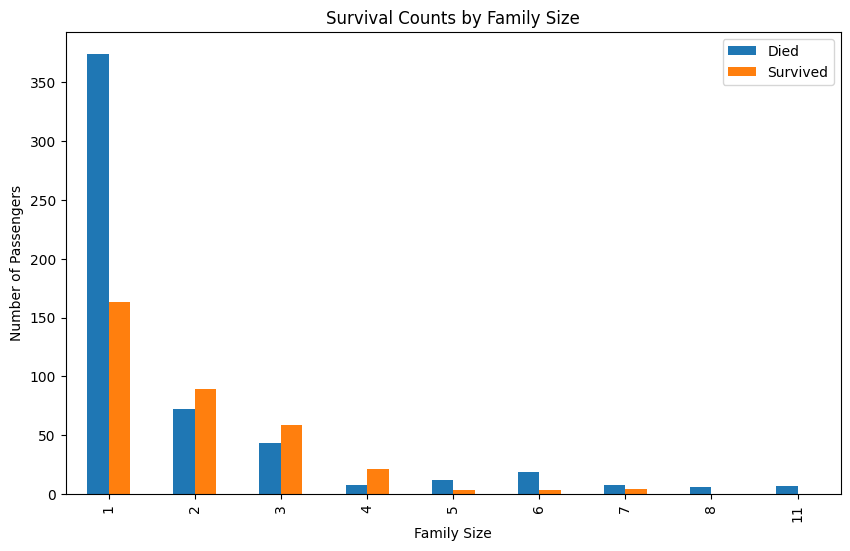

In [97]:
family_matters = pd.crosstab(df['FamilySize'], df['Survived'])

family_matters.plot(kind='bar', figsize=(10,6))

plt.xlabel("Family Size")
plt.ylabel("Number of Passengers")
plt.title("Survival Counts by Family Size")
plt.legend(["Died", "Survived"])
plt.show()


In [98]:
features = ['PassengerId', 'Pclass', 'Sex', 'Age', 'Fare', 'HasCabin', 'FamilySize', 'IsAlone', 'EmbarkedCat']  

X = df[features]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [99]:
clf = RandomForestClassifier()

param_dist = {
    'n_estimators': randint(100, 1000),      # Number of trees
    'max_depth': randint(2, 20),             # Max depth of each tree
    'min_samples_split': randint(2, 20),     # Minimum samples required to split a node
    'min_samples_leaf': randint(1, 20),      # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider at each split
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=200,          # Number of parameter settings sampled
    cv=5,               # 5-fold cross-validation
    scoring='accuracy', # Or another metric
    random_state=42,
    n_jobs=-1           # Use all cores
)

random_search.fit(X_train, y_train)
best = random_search.best_params_

param_grid = {
    'n_estimators': [best['n_estimators'] - 100, best['n_estimators'], best['n_estimators'] + 100],
    'max_depth': [best['max_depth'] - 2, best['max_depth'], best['max_depth'] + 2],
    'min_samples_split': [best['min_samples_split'] - 1, best['min_samples_split'], best['min_samples_split'] + 1], 'min_samples_leaf': [best['min_samples_leaf'] - 1, best['min_samples_leaf'], best['min_samples_leaf'] + 1],
    'max_features': [best['max_features']],          # keep fixed
    'bootstrap': [best['bootstrap']]                 # keep fixed
}

grid_search = GridSearchCV(
    estimator = clf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=1
)

grid_search.fit(X_train, y_train)

,estimator,RandomForestClassifier()
,param_grid,"{'bootstrap': [True], 'max_depth': [7, 9, ...], 'max_features': ['log2'], 'min_samples_leaf': [2, 3, ...], ...}"
,scoring,'accuracy'
,n_jobs,1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,287


In [100]:
y_pred = grid_search.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8156424581005587


i had used the wrong dataset for training/testing, but I'll copy the process to the correct one:

In [101]:
submission_df = pd.read_csv("test.csv") 

submission_df['Age'] = submission_df['Age'].fillna(submission_df['Age'].median())
submission_df['HasCabin'] = submission_df['Cabin'].notna().astype(int)
submission_df['FamilySize'] = submission_df['SibSp'] + submission_df['Parch'] + 1
submission_df['IsAlone'] = (submission_df['FamilySize'] == 1).astype(int)
submission_df['Sex'] = submission_df['Sex'].map({'male' : 0, 'female' : 1})
submission_df['Embarked'] = submission_df['Embarked'].fillna('Missing')
submission_df['EmbarkedCat'] = pd.factorize(submission_df['Embarked'])[0]

y_pred = grid_search.predict(submission_df[features])

pred_df = pd.DataFrame({
    'PassengerId': submission_df['PassengerId'],  
    'Survived': y_pred                     
})

pred_df.to_csv('predictions.csv', index=False)


In [ ]:
accuracy_score(y_pred, )

### Testing TabPFN

reference: https://github.com/PriorLabs/TabPFN 

In [102]:
clf = TabPFNClassifier()    
clf.fit(X_train, y_train)

,n_estimators,8
,categorical_features_indices,None
,softmax_temperature,0.9
,balance_probabilities,False
,average_before_softmax,False
,model_path,'auto'
,device,'auto'
,ignore_pretraining_limits,False
,inference_precision,'auto'
,fit_mode,'fit_preprocessors'
,memory_saving_mode,'auto'


In [103]:
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8156424581005587
Confusion Matrix:
 [[94 11]
 [22 52]]
